<a href="https://colab.research.google.com/github/AdirGelkop/Deep_Learning_Course_Project/blob/main/DL_v1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Project Notebook
This notebook documents the complete workflow for our deep learning project, starting with data preparation. Each section corresponds to a step in the project, and the notebook will be updated incrementally as we progress.

## **Introduction**
This project focuses on building a custom deep learning model for analyzing and predicting global economic indicators. The dataset used contains various economic metrics from 2010 to 2023. This notebook will cover all stages:
1. Data Preparation
2. Exploratory Data Analysis
3. Model Design and Training
4. Evaluation
5. Conclusions

## **1. Data Preparation**

In [1]:
#!pip install --upgrade pandas-datareader
#!pip install fredapi


### **1.1 Import Libraries**

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import torch.nn as nn
import torch
import torch.optim as optim
#import pandas_datareader as pdr
from fredapi import Fred

import warnings
# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning)  # Ignore SettingWithCopyWarning
warnings.filterwarnings("ignore", category=FutureWarning)  # Ignore FutureWarnings

#------------------------------------------------------------------------------

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.utils import shuffle
import kagglehub

# Set visualization styles
sns.set(style="whitegrid")

### **1.2 Download and Inspect the Dataset**

In [3]:
# Check if the dataset file exists and load it
#path = kagglehub.dataset_download("prasad22/global-economy-indicators")
path = kagglehub.dataset_download("heidarmirhajisadati/global-economic-indicators-dataset-2010-2023")
file_path = os.path.join(path, os.listdir(path)[0])  # Get the first file

if not os.path.exists(file_path):
    raise FileNotFoundError(f"The file {file_path} does not exist. Check the dataset download.")

# Load the dataset
print("Loading dataset...")
data = pd.read_csv(file_path)

# Display basic information about the dataset
print("\nDataset Info:")
data.info()

# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())
print("\nNo NaN treatment is required !")

# Only USA-related data
usa_data = data[data['Country'] == 'USA']

# Display the first 5 rows of the dataset
print("\nFirst 5 rows:\n")
usa_data.head()


Loading dataset...

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   500 non-null    object 
 1   Country                500 non-null    object 
 2   Inflation Rate (%)     500 non-null    float64
 3   GDP Growth Rate (%)    500 non-null    float64
 4   Unemployment Rate (%)  500 non-null    float64
 5   Interest Rate (%)      500 non-null    float64
 6   Stock Index Value      500 non-null    float64
dtypes: float64(5), object(2)
memory usage: 27.5+ KB

Missing Values:
Date                     0
Country                  0
Inflation Rate (%)       0
GDP Growth Rate (%)      0
Unemployment Rate (%)    0
Interest Rate (%)        0
Stock Index Value        0
dtype: int64

No NaN treatment is required !

First 5 rows:



,Date,Country,Inflation Rate (%),GDP Growth Rate (%),Unemployment Rate (%),Interest Rate (%),Stock Index Value
2,2010-01-31,USA,7.46,4.84,2.64,6.39,13129.10
7,2010-02-28,USA,3.13,4.82,9.32,-0.66,10638.13
9,2010-03-31,USA,7.20,-1.48,4.10,8.22,6067.71
17,2010-06-30,USA,5.56,0.87,4.54,3.34,2104.14
35,2011-01-31,USA,0.09,-1.82,11.92,-0.06,31674.37


### **1.3 Data Cleansing**

In [4]:
# Ensure Date column is in datetime format and set it as the index
usa_data['Date'] = pd.to_datetime(usa_data['Date'])
#usa_data = data.loc[data['Country'] == 'USA'].copy()
usa_data = usa_data.set_index('Date')

# Drop duplicate dates, keeping the first occurrence
usa_data = usa_data[~usa_data.index.duplicated(keep='first')]

# Resample to include all months (last day of each month)
usa_data = usa_data.resample('M').asfreq()

# Fill missing numeric columns with linear interpolation
usa_data = usa_data.interpolate(method='linear')
# Forward fill remaining "country" missing values
usa_data = usa_data.fillna(method='ffill')
usa_data = usa_data.fillna(method='bfill')

# Drop Stock Index Value as it is now irrelevant for 'GDP Growth Rate (%)'
usa_data = usa_data.drop(columns=['Stock Index Value'])

# Verify the final dataset
print("\nData after handling missing dates and values:\n")
usa_data.head()



Data after handling missing dates and values:



<ipython-input-4-0a92fae23eb3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usa_data['Date'] = pd.to_datetime(usa_data['Date'])


,Country,Inflation Rate (%),GDP Growth Rate (%),Unemployment Rate (%),Interest Rate (%)
Date,,,,,
2010-01-31,USA,7.460000,4.840000,2.640000,6.390000
2010-02-28,USA,3.130000,4.820000,9.320000,-0.660000
2010-03-31,USA,7.200000,-1.480000,4.100000,8.220000
2010-04-30,USA,6.653333,-0.696667,4.246667,6.593333
2010-05-31,USA,6.106667,0.086667,4.393333,4.966667


In [5]:
# Set FRED API key
fred_api_key = "9b7055aac3cb6bc9ec7b436a64703ff1"
fred = Fred(api_key=fred_api_key)

# Define the time range for data retrieval
start_date = '2010-01-01'
end_date = '2023-09-30'

# Define FRED symbols and their descriptions
external_features = {
    '10-Year Treasury Yield': 'GS10',  # Long-term interest rates
    'Nonfarm Payrolls': 'PAYEMS',  # Employment trends
    'Industrial Production': 'INDPRO',  # Economic output
    'Personal Consumption Expenditures': 'PCE',  # Consumer spending
    'US Leading Index': 'USSLIND',  # Economic outlook
    'Consumer Price Index (CPI)': 'CPIAUCSL',  # Inflation measure
}

# Fetch data from FRED and aggregate to monthly
external_data = {}
for desc, symbol in external_features.items():
    try:
        print(f"Fetching data for {desc} ({symbol})...")
        data = fred.get_series(symbol, observation_start=start_date, observation_end=end_date)

        # Convert to DataFrame and resample to monthly
        data = data.to_frame(name=desc).resample('M').mean()
        external_data[desc] = data
    except Exception as e:
        print(f"Failed to fetch {desc}. Error: {e}")

#10-Year Treasury Yield (GS10): Typically daily but resampled to monthly.
#Crude Oil Prices (WTI) (DCOILWTICO): Typically daily, resampled to monthly.
#Trade-Weighted US Dollar (DTWEXBGS): Typically weekly, resampled to monthly.
#Consumer Price Index (CPI) (CPIAUCSL): Already reported as monthly by FRED, so resampling won't change it.
#Unemployment Rate (UNRATE): Already reported as monthly by FRED.

# Combine data into a single DataFrame
external_df = pd.concat(external_data.values(), axis=1)
print("\nFetched data preview:")
external_df.head()


Fetching data for 10-Year Treasury Yield (GS10)...
Fetching data for Nonfarm Payrolls (PAYEMS)...
Fetching data for Industrial Production (INDPRO)...
Fetching data for Personal Consumption Expenditures (PCE)...
Fetching data for US Leading Index (USSLIND)...
Fetching data for Consumer Price Index (CPI) (CPIAUCSL)...

Fetched data preview:


,10-Year Treasury Yield,Nonfarm Payrolls,Industrial Production,Personal Consumption Expenditures,US Leading Index,Consumer Price Index (CPI)
2010-01-31,3.73,129795.0,89.1897,10056.1,0.54,217.488
2010-02-28,3.69,129702.0,89.5046,10093.4,0.76,217.281
2010-03-31,3.73,129865.0,90.1356,10156.0,1.10,217.353
2010-04-30,3.85,130115.0,90.4607,10182.3,1.14,217.403
2010-05-31,3.42,130645.0,91.7014,10210.8,1.42,217.290


In [6]:
# Ensure the indices are datetime and aligned
external_df.index = pd.to_datetime(external_df.index)
usa_data.index = pd.to_datetime(usa_data.index)

# Merge external data with the main dataset
merged_data = usa_data.merge(external_df, left_index=True, right_index=True, how='left')

# Fill missing values with interpolation or forward/backward fill
merged_data = merged_data.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')

usa_data = merged_data.drop(columns=['Country'])

# Move GDP Growth Rate (%) to the last column for visual purposes
columns = [col for col in usa_data.columns if col != 'GDP Growth Rate (%)'] + ['GDP Growth Rate (%)']
usa_data = usa_data[columns]

# Preview the merged dataset
print("\nMerged dataset preview:")
usa_data.head()



Merged dataset preview:


,Inflation Rate (%),Unemployment Rate (%),Interest Rate (%),10-Year Treasury Yield,Nonfarm Payrolls,Industrial Production,Personal Consumption Expenditures,US Leading Index,Consumer Price Index (CPI),GDP Growth Rate (%)
Date,,,,,,,,,,
2010-01-31,7.460000,2.640000,6.390000,3.73,129795.0,89.1897,10056.1,0.54,217.488,4.840000
2010-02-28,3.130000,9.320000,-0.660000,3.69,129702.0,89.5046,10093.4,0.76,217.281,4.820000
2010-03-31,7.200000,4.100000,8.220000,3.73,129865.0,90.1356,10156.0,1.10,217.353,-1.480000
2010-04-30,6.653333,4.246667,6.593333,3.85,130115.0,90.4607,10182.3,1.14,217.403,-0.696667
2010-05-31,6.106667,4.393333,4.966667,3.42,130645.0,91.7014,10210.8,1.42,217.290,0.086667


### **3.2 GRU Model**

Epoch 10/50, Loss: 13.6466
Epoch 20/50, Loss: 11.9508
Epoch 30/50, Loss: 9.3923
Epoch 40/50, Loss: 7.8333
Epoch 50/50, Loss: 6.4876
GRU Model MAPE: 116.56%


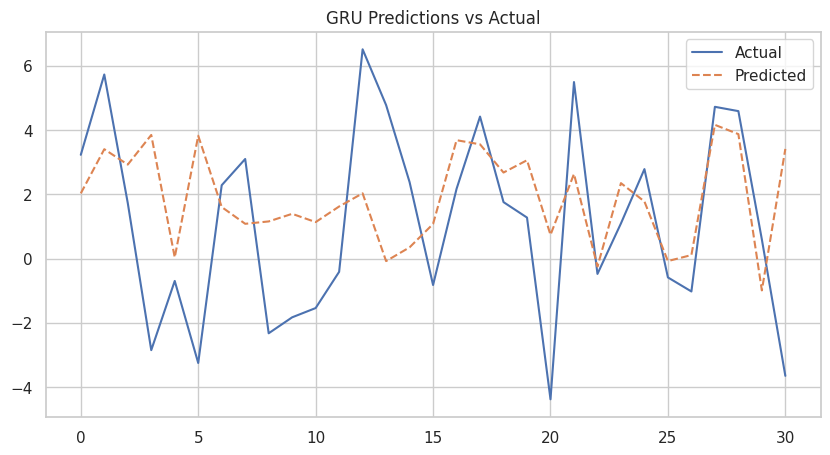

In [13]:
usa_data_for_GRU = usa_data
#.drop(columns=['Inflation Rate (%)', 'Unemployment Rate (%)', 'Interest Rate (%)',
#                     '10-Year Treasury Yield','Nonfarm Payrolls','Industrial Production',
#                     'Personal Consumption Expenditures','US Leading Index','Consumer Price Index (CPI)'])

# Handle missing values (fill missing with forward fill, then backward fill)
usa_data_for_GRU = usa_data_for_GRU.fillna(method='ffill').fillna(method='bfill')

# Standardize features
scaler = StandardScaler()
features = [col for col in usa_data_for_GRU.columns if col != 'GDP Growth Rate (%)']
usa_data_for_GRU[features] = scaler.fit_transform(usa_data_for_GRU[features])

#print(usa_data_for_GRU)

window_size = 12
X = usa_data_for_GRU[features].values.astype(float)
y = usa_data_for_GRU['GDP Growth Rate (%)'].values.astype(float)

def create_sequences(data_x, data_y, window=12):
    sequence_x, sequence_y = [], []
    for i in range(len(data_x) - window):
        sequence_x.append(data_x[i:i+window])
        sequence_y.append(data_y[i+window])
    return np.array(sequence_x, dtype=np.float32), np.array(sequence_y, dtype=np.float32)

X_seq, y_seq = create_sequences(X, y, window=window_size)

# Step 5: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Step 6: Convert to PyTorch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.float32).to(device)

# Define GRU model with Dropout
class GRURegressor(nn.Module):
    def __init__(self, input_size, hidden_size=64, dropout=0.2):
        super().__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out.squeeze(-1)

# Instantiate the GRU model
input_size = X_train.shape[2]
gru_model = GRURegressor(input_size=input_size, hidden_size=64, dropout=0.2).to(device)

# Optimizer and learning rate scheduler
optimizer = optim.Adam(gru_model.parameters(), lr=0.001)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Train the GRU model with early stopping
epochs = 50
early_stopping_patience = 10
best_loss = float('inf')
early_stop_counter = 0

gru_model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = gru_model(X_train_t)
    loss = criterion(predictions, y_train_t)
    loss.backward()
    optimizer.step()
    scheduler.step(loss.item())  # Adjust learning rate based on loss

    # Early stopping logic
    if loss.item() < best_loss:
        best_loss = loss.item()
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

    if early_stop_counter >= early_stopping_patience:
        print("Early stopping triggered.")
        break

# Evaluate the GRU model
gru_model.eval()
gru_predictions = []
with torch.no_grad():
    for i in range(X_test_t.shape[0]):
        sequence = X_test_t[i].unsqueeze(0)
        pred = gru_model(sequence)
        gru_predictions.append(pred.item())

# Calculate evaluation metrics
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100

mape = mean_absolute_percentage_error(y_test, gru_predictions)
print(f"GRU Model MAPE: {mape:.2f}%")

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(range(len(y_test)), y_test, label="Actual")
plt.plot(range(len(gru_predictions)), gru_predictions, label="Predicted", linestyle='--')
plt.title("GRU Predictions vs Actual")
plt.legend()
plt.show()


### **1.4 Feature Engineering**

In [ ]:
# Derived Features
usa_data['Industrial Growth'] = usa_data['Industrial Production'] / usa_data['Nonfarm Payrolls']
usa_data['Economic Activity Index'] = (usa_data['Personal Consumption Expenditures'] +
                                          usa_data['Industrial Production']) * usa_data['US Leading Index']

# Rolling Statistics
usa_data['CPI_3M_Rolling_Mean'] = usa_data['Consumer Price Index (CPI)'].rolling(window=3).mean()
usa_data['Unemployment_3M_Rolling_Std'] = usa_data['Unemployment Rate (%)'].rolling(window=3).std()

# Lagged Features
for col in ['Inflation Rate (%)', 'GDP Growth Rate (%)', '10-Year Treasury Yield', 'Unemployment Rate (%)', 'Industrial Production']:
    usa_data[f'{col}_Lag_1'] = usa_data[col].shift(1)

# Handle Missing Values
usa_data.fillna(method='bfill', inplace=True)
usa_data.fillna(method='ffill', inplace=True)

# Verify the Engineered Data
print("\nEngineered Features Preview:")
usa_data.head()


In [ ]:
# 1. Create longer lagged features (3-month and 6-month lags for key features)
usa_data['Inflation Rate (%)_Lag3'] = usa_data['Inflation Rate (%)'].shift(3)
usa_data['Inflation Rate (%)_Lag6'] = usa_data['Inflation Rate (%)'].shift(6)
usa_data['Interest Rate (%)_Lag3'] = usa_data['Interest Rate (%)'].shift(3)
usa_data['Interest Rate (%)_Lag6'] = usa_data['Interest Rate (%)'].shift(6)

# 2. Add longer rolling statistics (6-month and 12-month rolling averages for key features)
usa_data['Inflation Rate (%)_MA6'] = usa_data['Inflation Rate (%)'].rolling(window=6).mean()
usa_data['Inflation Rate (%)_MA12'] = usa_data['Inflation Rate (%)'].rolling(window=12).mean()
usa_data['Interest Rate (%)_MA6'] = usa_data['Interest Rate (%)'].rolling(window=6).mean()
usa_data['Interest Rate (%)_MA12'] = usa_data['Interest Rate (%)'].rolling(window=12).mean()

# 3. Create new feature interactions
usa_data['Inflation_Interest_Ratio'] = usa_data['Inflation Rate (%)'] / usa_data['Interest Rate (%)']
usa_data['Employment_Gap'] = 100 - usa_data['Unemployment Rate (%)']


In [ ]:
features = usa_data.drop(columns=['GDP Growth Rate (%)'])  # Exclude the target
target = usa_data['GDP Growth Rate (%)']

scaler = MinMaxScaler()
# Scale features
scaled_features = scaler.fit_transform(features)
# Convert back to a DataFrame for readability
scaled_features_df = pd.DataFrame(scaled_features, columns=features.columns, index=features.index)

# Combine scaled features with the target for final dataset
final_data = pd.concat([scaled_features_df, target], axis=1)

usa_data = final_data

# Handle Missing Values
usa_data.fillna(method='bfill', inplace=True)
usa_data.fillna(method='ffill', inplace=True)

# Verify the structure
usa_data.tail()



## **2. Exploratory Data Analysis**

### **2.1 Visualizations**

In [ ]:
# Ensure time-series correlation calculation using Spearman and absolute values
correlation = usa_data.corr(method='spearman').abs()  # Spearman correlation and absolute values

# Sort correlations with GDP Growth Rate (%)
gdp_correlation = correlation['GDP Growth Rate (%)'].sort_values(ascending=False)
print("\nCorrelation with GDP Growth Rate (%):")
print(gdp_correlation)

# Plot heatmap for correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap (Spearman, Absolute Values)")
plt.show()

# Line plot for GDP Growth Rate over time
plt.figure(figsize=(12, 6))
plt.plot(usa_data.index, usa_data['GDP Growth Rate (%)'], label='GDP Growth Rate (%)', color='blue')
plt.title("GDP Growth Rate (%) Over Time")
plt.xlabel("Time")
plt.ylabel("GDP Growth Rate (%)")
plt.legend()
plt.grid(True)
plt.show()

# Pairplot for feature relationships
selected_features = ['Inflation Rate (%)', 'Unemployment Rate (%)', 'Interest Rate (%)',
                     '10-Year Treasury Yield','Nonfarm Payrolls','Industrial Production',
                     'Personal Consumption Expenditures','US Leading Index','Consumer Price Index (CPI)']
sns.pairplot(usa_data, vars=selected_features + ['GDP Growth Rate (%)'], diag_kind='kde', height=2.5)
plt.suptitle("Pairplot for Feature Relationships", y=1.02)
plt.show()


### **2.2 Preparing The 'usa_data' For Model Run**
### **Shifting Prediction**
### **Splitting to Train-set, Test-set, Future_row for Prediction**

In [ ]:
# Shift Bitcoin_Price column upwards by one row to predict next day's price
usa_data['GDP Growth Rate (%)'] = usa_data['GDP Growth Rate (%)'].shift(-1)

# Drop the Date column as it is not a feature
usa_data = usa_data.drop(columns=['Date', 'Country'], errors='ignore')

# Separate the last row for future prediction
future_row = usa_data.iloc[[-1]]
usa_data = usa_data.iloc[:-1]

# Split the data into features (X) and prediction target (y)
X = usa_data.drop(columns=['GDP Growth Rate (%)'])  # Features
y = usa_data['GDP Growth Rate (%)']                # Target variable

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the resulting datasets for verification
print("Training set shape (X_train, y_train):", X_train.shape, y_train.shape)
print("Testing set shape (X_test, y_test):", X_test.shape, y_test.shape)

# Display the future row for prediction verification
print("\nFuture row for prediction:")
future_row

## **3. Model Design and Training**

### **3.1 Random Forest Model**

In [ ]:
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Configure and run the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)  # Configure the model

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='r2', verbose=2, n_jobs=-1)

y_train = y_train.values

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best R^2 Score:", grid_search.best_score_)


In [ ]:
# Retrieve the best model from GridSearchCV
best_rf_model = grid_search.best_estimator_

# Evaluate the model on the testing set
y_pred = best_rf_model.predict(X_test)
print("\nModel Evaluation:")
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R^2 Score:", r2_score(y_test, y_pred))

# Predict the Bitcoin price for the future row
future_prediction = best_rf_model.predict(future_row.drop(columns=['GDP Growth Rate (%)'], errors='ignore'))
print("\nPredicted GDP Growth Rate (%) for the future row:", future_prediction)

### **3.3 LSTM Model**

In [ ]:
# Define the LSTM model for predicting GDP Growth Rate (%)
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size=32):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out.squeeze(-1)

# Instantiate the LSTM model
input_size = X_train.shape[2]
lstm_model = LSTMRegressor(input_size=input_size, hidden_size=32).to(device)
optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=0.001)
criterion_lstm = nn.MSELoss()

# Train the LSTM model
epochs = 50
lstm_model.train()
for epoch in range(epochs):
    optimizer_lstm.zero_grad()
    predictions = lstm_model(X_train_t)
    loss = criterion_lstm(predictions, y_train_t)
    loss.backward()
    optimizer_lstm.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# Evaluate the LSTM model
lstm_model.eval()
lstm_predictions = []
with torch.no_grad():
    for i in range(X_test_t.shape[0]):
        sequence = X_test_t[i].unsqueeze(0)
        pred = lstm_model(sequence)
        lstm_predictions.append(pred.item())

# Calculate evaluation metrics for LSTM
lstm_mape = mean_absolute_percentage_error(y_test, lstm_predictions)
print(f"LSTM Model MAPE: {lstm_mape:.2f}%")

# Plot results for LSTM
plt.figure(figsize=(10, 5))
plt.plot(range(len(y_test)), y_test, label="Actual")
plt.plot(range(len(lstm_predictions)), lstm_predictions, label="Predicted", linestyle='--')
plt.title("LSTM Predictions vs Actual")
plt.legend()
plt.show()


In [ ]:
# Define a Transformer-based model for predicting GDP Growth Rate (%)
class TransformerRegressor(nn.Module):
    def __init__(self, input_size, num_heads=4, hidden_size=64, num_layers=2, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(input_size, hidden_size)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size, nhead=num_heads, dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.input_proj(x)  # Project input to the transformer dimension
        x = self.transformer(x)  # Pass through the transformer encoder
        x = self.fc(x[:, -1, :])  # Take the output of the last time step for prediction
        return x.squeeze(-1)

# Instantiate the Transformer model
input_size = X_train.shape[2]
transformer_model = TransformerRegressor(
    input_size=input_size, num_heads=4, hidden_size=64, num_layers=2, dropout=0.1
).to(device)
optimizer_transformer = optim.Adam(transformer_model.parameters(), lr=0.001)
criterion_transformer = nn.MSELoss()

# Train the Transformer model
epochs = 50
transformer_model.train()
for epoch in range(epochs):
    optimizer_transformer.zero_grad()
    predictions = transformer_model(X_train_t)
    loss = criterion_transformer(predictions, y_train_t)
    loss.backward()
    optimizer_transformer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# Evaluate the Transformer model
transformer_model.eval()
transformer_predictions = []
with torch.no_grad():
    for i in range(X_test_t.shape[0]):
        sequence = X_test_t[i].unsqueeze(0)
        pred = transformer_model(sequence)
        transformer_predictions.append(pred.item())

# Calculate evaluation metrics for the Transformer model
transformer_mape = mean_absolute_percentage_error(y_test, transformer_predictions)
print(f"Transformer Model MAPE: {transformer_mape:.2f}%")

# Plot results for the Transformer model
plt.figure(figsize=(10, 5))
plt.plot(range(len(y_test)), y_test, label="Actual")
plt.plot(range(len(transformer_predictions)), transformer_predictions, label="Predicted", linestyle='--')
plt.title("Transformer Predictions vs Actual")
plt.legend()
plt.show()


In [ ]:
# Define a TCN block
class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation_rate, dropout_rate=0.2):
        super(TCNBlock, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=(kernel_size - 1) * dilation_rate, dilation=dilation_rate)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.residual = nn.Conv1d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else None
        self.batch_norm = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        residual = x
        x = self.conv(x)
        x = self.relu(x)
        x = self.dropout(x)
        if self.residual:
            residual = self.residual(residual)
        return self.batch_norm(x + residual)

# Define the TCN model
# Define a TCN block with corrected padding
class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation_rate, dropout_rate=0.2):
        super(TCNBlock, self).__init__()
        self.conv = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size,
            padding=(kernel_size - 1) * dilation_rate // 2,  # Correct padding to maintain the same seq_len
            dilation=dilation_rate,
        )
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.residual = (
            nn.Conv1d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else None
        )
        self.batch_norm = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        residual = x
        x = self.conv(x)
        x = self.relu(x)
        x = self.dropout(x)
        if self.residual:
            residual = self.residual(residual)
        return self.batch_norm(x + residual)

# Prepare the dataset
def prepare_data(usa_data, target_column, sequence_length=12):
    X, y = [], []
    for i in range(len(usa_data) - sequence_length):
        X.append(usa_data.iloc[i:i + sequence_length, :-1].values)
        y.append(usa_data.iloc[i + sequence_length][target_column])
    X = np.array(X, dtype=np.float32).transpose(0, 2, 1)  # Shape: [samples, features, time]
    y = np.array(y, dtype=np.float32)
    return torch.tensor(X), torch.tensor(y)

# Load and prepare data
target_column = "GDP Growth Rate (%)"
sequence_length = 12  # 12 months of historical data
X, y = prepare_data(usa_data, target_column, sequence_length)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
input_size = X.shape[1]  # Number of features
output_size = 1  # Predicting a single target value
num_channels = 64  # Number of channels for TCN layers
kernel_size = 3  # Kernel size for convolutional layers

tcn_model = TCNModel(input_size=input_size, output_size=output_size, num_channels=num_channels, kernel_size=kernel_size)
# Define optimizer and loss function
optimizer = optim.Adam(tcn_model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Train the model
num_epochs = 50
batch_size = 32
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(1, num_epochs + 1):
    tcn_model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = tcn_model(X_batch)
        loss = criterion(predictions.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

# Evaluate the model
tcn_model.eval()
with torch.no_grad():
    y_pred = tcn_model(X_test).squeeze()
    mse = criterion(y_pred, y_test)
    print(f"TCN Model MSE: {mse.item():.4f}")
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"TCN Model RMSE: {rmse:.4f}")
    r2 = r2_score(y_test, y_pred)
    print(f"TCN Model R²: {r2:.4f}")


# Plot predictions vs actual values
y_pred = y_pred.numpy()
y_test = y_test.numpy()

plt.figure(figsize=(10, 6))
plt.plot(y_test, label="True")
plt.plot(y_pred, label="Predicted")
plt.legend()
plt.title("TCN Model Predictions vs True Values")
plt.show()


In [ ]:
# Corrected WaveNet Implementation
class WaveNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation_rate):
        super(WaveNetBlock, self).__init__()
        self.padding = (kernel_size - 1) * dilation_rate
        self.dilated_conv = nn.Conv1d(
            in_channels, out_channels, kernel_size,
            padding=self.padding, dilation=dilation_rate
        )
        self.gate_conv = nn.Conv1d(
            in_channels, out_channels, kernel_size,
            padding=self.padding, dilation=dilation_rate
        )
        self.residual_conv = nn.Conv1d(out_channels, out_channels, kernel_size=1)
        self.skip_conv = nn.Conv1d(out_channels, out_channels, kernel_size=1)

    def forward(self, x):
        conv = torch.tanh(self.dilated_conv(x))
        gate = torch.sigmoid(self.gate_conv(x))
        output = conv * gate
        residual = self.residual_conv(output)
        skip = self.skip_conv(output)

        # Adjust sizes
        residual = residual[..., :x.size(-1)]
        skip = skip[..., :x.size(-1)]
        return (x + residual), skip

class WaveNet(nn.Module):
    def __init__(self, input_channels, num_blocks, kernel_size, dilation_rates):
        super(WaveNet, self).__init__()
        self.blocks = nn.ModuleList([
            WaveNetBlock(input_channels, input_channels, kernel_size, dilation_rate)
            for dilation_rate in dilation_rates
        ])
        self.global_pool = nn.AdaptiveAvgPool1d(1)  # Pool time dimension to 1
        self.final_fc = nn.Linear(input_channels, 1)  # Fully connected for single output

    def forward(self, x):
        skip_connections = []
        for block in self.blocks:
            x, skip = block(x)
            skip_connections.append(skip)
        x = sum(skip_connections)  # Sum all skip connections
        x = torch.relu(x)
        x = self.global_pool(x).squeeze(-1)  # Reduce to [batch_size, input_channels]
        x = self.final_fc(x)  # Output a single value
        return x


# Prepare Data
def prepare_data(usa_data, target_column, sequence_length=12):
    X, y = [], []
    for i in range(len(usa_data) - sequence_length):
        X.append(usa_data.iloc[i:i + sequence_length, :-1].values.T)  # [features, time]
        y.append(usa_data.iloc[i + sequence_length][target_column])
    X = np.array(X, dtype=np.float32)  # [samples, features, time]
    y = np.array(y, dtype=np.float32)
    return torch.tensor(X), torch.tensor(y)

# Prepare dataset
X, y = prepare_data(usa_data, target_column, sequence_length)
input_channels = X.shape[1]  # Number of features (not 1)

# Ensure input shape is [batch_size, input_channels, sequence_length]
print(f"Input shape: {X.shape}")  # Debugging shape
print(f"Input tensor shape: {X.shape}")  # Debugging
# Expected: [samples, features, time] e.g., [152, 28, 12]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Model
input_channels = X.shape[1]  # Number of features (28 in this case)
num_blocks = 6
kernel_size = 2
dilation_rates = [2**i for i in range(num_blocks)]

wavenet_model = WaveNet(input_channels=input_channels, num_blocks=num_blocks, kernel_size=kernel_size, dilation_rates=dilation_rates)

# Training Setup
optimizer = optim.Adam(wavenet_model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Train Model
num_epochs = 50
batch_size = 32
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(1, num_epochs + 1):
    wavenet_model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = wavenet_model(X_batch)
        loss = criterion(predictions.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

# Evaluate Model
wavenet_model.eval()
with torch.no_grad():
    y_pred = wavenet_model(X_test).squeeze()
    mse = criterion(y_pred, y_test)
    print(f"WaveNet Model MSE: {mse.item():.4f}")

# Plot Predictions
y_pred = y_pred.numpy()
y_test = y_test.numpy()

plt.figure(figsize=(10, 6))
plt.plot(y_test, label="True")
plt.plot(y_pred, label="Predicted")
plt.legend()
plt.title("WaveNet Model Predictions vs True Values")
plt.show()
